In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.linalg
import scipy
import copy

In [2]:
seed = 58
train_num = 45
wd1_mode = 0

def train(params):
    
    eta2 = params[0]
    wd2 = params[1]
    epochs = int(params[2])
    
    init_scale = 1
    log = 100
    if wd1_mode == 0:
        wd1 = 0
    else:
        wd1 = wd2

    iters = []

    np.random.seed(seed)
    torch.manual_seed(seed)
    print("train_num={}".format(train_num))
    print("seed={}".format(seed))

    #train_num = 30

    input_dim = 10
    latent_dim = 1
    output_dim = 30
    p = 10
    x_templates = np.random.normal(0,1,size=(p, output_dim))
    y_templates = np.random.normal(0,1,size=(2*p-1, output_dim))
    x_templates = torch.tensor(x_templates, dtype=torch.float, requires_grad=True)
    y_templates = torch.tensor(y_templates, dtype=torch.float, requires_grad=True)

    D0_id = []
    xx_id = []
    yy_id = []
    for i in range(p):
        for j in range(i,p):
            D0_id.append((i,j))
            xx_id.append(i)
            yy_id.append(j)

    xx_id = np.array(xx_id)
    yy_id = np.array(yy_id)

    base = 0
    for i in range(1,p):
        for j in range(i+1,p):
            for m in range(j,p):
                for n in range(m+1,p):
                    if (i+n-j-m) == 0:
                        base = base + 1


    # neural network part
    all_num = int(p*(p+1)/2)
    train_id = np.random.choice(all_num,train_num, replace=False)
    test_id = np.array(list(set(np.arange(all_num)) - set(train_id)))
    #xx_id = xx_id.reshape(-1,)[train_id]
    #yy_id = yy_id.reshape(-1,)[train_id]
    
    inputs_id = np.transpose(np.array([xx_id,yy_id]))
    out_id = (xx_id + yy_id)

    labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
    inputs_train = torch.cat([x_templates[xx_id[train_id]],x_templates[yy_id[train_id]]], dim=1)
    out_id_train = out_id[train_id]

    labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)
    inputs_test = torch.cat([x_templates[xx_id[test_id]],x_templates[yy_id[test_id]]], dim=1)
    out_id_test = out_id[test_id]



    # P0
    P0 = []
    P0_id = []

    ii = 0
    for i in range(all_num):
        for j in range(i+1,all_num):
            if np.sum(D0_id[i]) == np.sum(D0_id[j]):
                P0.append(frozenset({D0_id[i], D0_id[j]}))
                P0_id.append(ii)
                ii += 1

    P0_num = len(P0_id)

    # A
    A = []
    eq_id = 0

    for i1 in range(P0_num):
        i,j = list(P0[i1])[0]
        m,n = list(P0[i1])[1]
        if i+j==m+n:
            x = np.zeros(p,)
            x[i] = x[i] + 1; 
            x[j] = x[j] + 1; 
            x[m] = x[m] - 1;
            x[n] = x[n] - 1;
            A.append(x)
            eq_id = eq_id + 1

    A = np.array(A).astype(int)


    # P0(D)
    P0D_id = []

    ii = 0
    for i in range(all_num):
        for j in range(i+1,all_num):
            if np.sum(D0_id[i]) == np.sum(D0_id[j]):
                if i in train_id and j in train_id:
                    P0D_id.append(ii)
                ii += 1

    P0D = []
    for i in P0D_id:
        P0D.append(P0[i])

    # P0D_c
    P0D_c_id = set(P0_id) - set(P0D_id)


    # PD
    PD_id = []

    for i in P0D_c_id:
        P0D_id_aug = copy.deepcopy(P0D_id)
        P0D_id_aug.append(i)
        P0D_aug = []
        for j in P0D_id_aug:
            P0D_aug.append(P0[j])
        null_dim_1 = np.sum(np.linalg.eigh(np.matmul(np.transpose(A[P0D_id]),A[P0D_id]))[0] < 1e-8)
        null_dim_2 = np.sum(np.linalg.eigh(np.matmul(np.transpose(A[P0D_id_aug]),A[P0D_id_aug]))[0] < 1e-8)
        if null_dim_1 == null_dim_2:
            PD_id.append(i)

    PD_id = PD_id + P0D_id

    PD = []
    for i in PD_id:
        PD.append(P0[i])



    # Dbar(D)
    Dbar_id = list(copy.deepcopy(train_id))

    for i1 in test_id:
        flag = 0
        for j1 in train_id:
            i, j = D0_id[i1]
            m, n = D0_id[j1]
            if {(i,j),(m,n)} in PD:
                flag = 1
                break
        if flag == 1:
            Dbar_id.append(i1)

    acc_ideal = len(Dbar_id)/all_num
    acc_ideal_test = (len(Dbar_id)-len(train_id))/len(test_id)
    print("acc_ideal_test = {}/{}={}".format(len(Dbar_id)-len(train_id),len(test_id),acc_ideal_test))


    class NET(nn.Module):
        def __init__(self, input_dim, output_dim, w=200):
            super(NET, self).__init__()
            self.l1 = nn.Linear(input_dim, w)
            self.l2 = nn.Linear(w, w)
            self.l3 = nn.Linear(w, output_dim)

        def forward(self, x):
            f = torch.nn.Tanh()
            self.x1 = f(self.l1(x))
            self.x2 = f(self.l2(self.x1))
            self.x3 = self.l3(self.x2)
            return self.x3

    class DEC(nn.Module):
        def __init__(self, input_dim, output_dim, w=200):
            super(DEC, self).__init__()
            self.net = NET(input_dim, output_dim, w=200)

        def forward(self, latent, x_id):
            self.add1 = latent[x_id[:,0]]
            self.add2 = latent[x_id[:,1]]
            self.add = self.add1 + self.add2
            self.out = self.net(self.add)
            return self.out


    class AE(nn.Module):

        def __init__(self, w=200, input_dim=1, output_dim=1):
            super(AE, self).__init__()
            self.enc = NET(input_dim, latent_dim, w=w)
            self.dec = DEC(latent_dim, output_dim, w=w)

        def forward(self, x, x_id):
            self.latent = self.enc(x)
            self.out = self.dec(self.latent,x_id)

            return self.out





    model = AE(input_dim=input_dim, output_dim=output_dim, w=200)

    ccs_epoch = []
    ccs2_epoch = []

    print("eta2={}".format(eta2))
    eta1 = 1e-3

    #latent = torch.nn.parameter.Parameter(torch.normal(0,init_scale,size=(p,latent_dim)))
    latent = torch.nn.parameter.Parameter((torch.rand(p,latent_dim)-1/2)*init_scale)
    optimizer1 = torch.optim.AdamW({latent}, lr=eta1, weight_decay=wd1)
    optimizer2 = torch.optim.AdamW(model.dec.parameters(), lr=eta2, weight_decay=wd2)
    #optimizer2 = torch.optim.Adam(model.dec.parameters(), lr=eta2)
    
    reach_acc_test = False
    reach_acc_train = False
    reach_rqi = False

    for epoch in range(epochs):  # loop over the dataset multiple times

        optimizer1.zero_grad()
        optimizer2.zero_grad()

        outputs_train = model.dec(latent, inputs_id[train_id])
        outputs_test = model.dec(latent, inputs_id[test_id])
        loss_train = torch.mean((outputs_train-labels_train)**2)
        loss_train.backward()
        optimizer1.step()
        optimizer2.step()


        # accuracy
        outputs_train = model.dec(latent, inputs_id[train_id])
        outputs_test = model.dec(latent, inputs_id[test_id])
        pred_train_id = torch.argmin(torch.sum((outputs_train.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
        pred_test_id = torch.argmin(torch.sum((outputs_test.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
        #print(pred_train_id.detach().numpy())
        acc_nn_train = np.mean(pred_train_id.detach().numpy() == out_id_train)
        acc_nn_test = np.mean(pred_test_id.detach().numpy() == out_id_test)
        acc_nn = (acc_nn_train*train_id.shape[0] + acc_nn_test*test_id.shape[0])/all_num

        if not reach_acc_test:
            if acc_nn_test >= 0.9:
                reach_acc_test = True
                iter_test = epoch

        if not reach_acc_train:
            if acc_nn_train >= 0.9:
                reach_acc_train = True
                iter_train = epoch

        if epoch % log == 0:
            print("epoch: %d  | loss: %.8f "%(epoch, loss_train.detach().numpy()))

        latent_scale = latent/torch.std(latent,dim=0).unsqueeze(dim=0)
        base = 0
        count = 0
        count2 = 0
        for i in range(1,p):
            for j in range(i+1,p):
                for m in range(j,p):
                    for n in range(m+1,p):
                        if (i+n-j-m) == 0:
                            base = base + 1
                            dist = latent_scale[i] + latent_scale[n] - latent_scale[m] - latent_scale[j]
                            count = count + torch.sum(dist**2)
                            count2 = count2 + (torch.sum(dist**2)<0.01)
        rqi = count2/base
        if not reach_rqi:
            if rqi > 0.95:
                reach_rqi = True
                iter_rqi = epoch

    if not reach_acc_test:
        iter_test = epoch

    if not reach_acc_train:
        iter_train = epoch

    if not reach_rqi:
        iter_rqi = epoch

    np.savetxt("./pd_results/seed_%d_wd1_%d/train_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2), [iter_train])
    np.savetxt("./pd_results/seed_%d_wd1_%d/test_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2), [iter_test])
    np.savetxt("./pd_results/seed_%d_wd1_%d/rqi_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2), [rqi])
    return acc_ideal_test, iters

In [2]:
dec_lrs = 10**np.linspace(-4,-2,num=11)
wds = list(np.arange(11)) + [20]

#seed_9_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.4,-2.8,num=11)
#wds = np.linspace(5,8,num=11)

#seed_25_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.6,-3.2,num=11)
#wds = np.linspace(7,9,num=11)

#seed_58_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.6,-3.2,num=11)
#wds = np.linspace(6,8,num=11)

epochs = [1e5]

xx, yy, zz = np.meshgrid(dec_lrs, wds, epochs)
params = list(np.transpose(np.array([xx.reshape(-1,), yy.reshape(-1,), zz.reshape(-1,)])))

from multiprocess import Pool

if __name__ == '__main__':
    with Pool(11) as p:
        print(p.map(train, params))

NameError: name 'train' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt

dec_lrs = 10**np.linspace(-4,-2,num=11)
wds = list(np.arange(11)) + [20]

#seed_9_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.4,-2.8,num=11)
#wds = np.linspace(5,8,num=11)

#seed_25_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.6,-3.2,num=11)
#wds = np.linspace(7,9,num=11)

#seed_58_wd1_0_fine
#dec_lrs = 10**np.linspace(-3.6,-3.2,num=11)
#wds = np.linspace(6,8,num=11)

train_iterss = []
test_iterss = []
rqiss = []
for j in range(11):
    train_iters = []
    test_iters = []
    rqis = []
    for k in range(11):
        eta2 = dec_lrs[j]
        wd2 = wds[k]
        train_iter = np.loadtxt("./pd_results/seed_%d_wd1_%d/train_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2))
        test_iter = np.loadtxt("./pd_results/seed_%d_wd1_%d/test_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2))
        rqi = np.loadtxt("./pd_results/seed_%d_wd1_%d/rqi_eta2_%.5f_wd_%.1f.txt"%(seed,wd1_mode,eta2,wd2))
        train_iters.append(train_iter)
        test_iters.append(test_iter)
        rqis.append(rqi)
    train_iterss.append(train_iters)
    test_iterss.append(test_iters)
    rqiss.append(rqis)
    
train_iterss = np.array(train_iterss)
test_iterss = np.array(test_iterss)
rqiss = np.array(rqiss)


Text(0.5, 1.0, 'RQI')

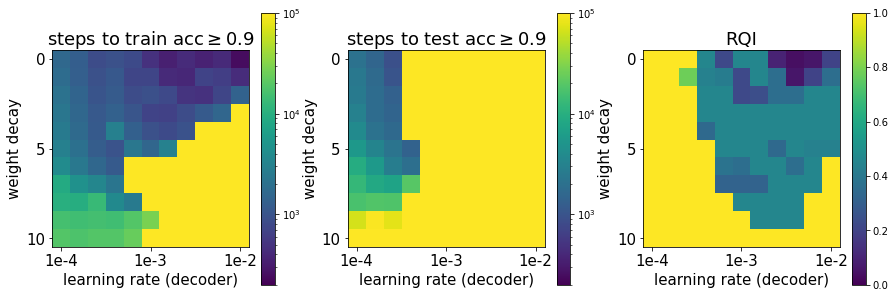

In [5]:
import matplotlib

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)

plt.imshow(np.transpose(train_iterss[:]),norm=matplotlib.colors.LogNorm())
plt.xlabel("learning rate (decoder)",fontsize=15)
plt.ylabel("weight decay",fontsize=15)
plt.yticks([0,5,10],[wds[0], wds[5], wds[10]],fontsize=15)
#plt.xticks([0,5,10], [dec_lrs[0], dec_lrs[5], dec_lrs[10]])
plt.xticks([0,5,10], ["1e-4", "1e-3", "1e-2"],fontsize=15)
plt.colorbar()
plt.clim(200,1e5)
plt.title('steps to train acc'+r"$\geq 0.9$",fontsize=18)

plt.subplot(1,3,2)

plt.imshow(np.transpose(test_iterss[:]),norm=matplotlib.colors.LogNorm())
plt.xlabel("learning rate (decoder)",fontsize=15)
plt.ylabel("weight decay",fontsize=15)
plt.yticks([0,5,10],[wds[0], wds[5], wds[10]],fontsize=15)
plt.xticks([0,5,10], ["1e-4", "1e-3", "1e-2"],fontsize=15)
plt.colorbar()
plt.clim(200,1e5)
plt.title('steps to test acc'+r"$\geq 0.9$",fontsize=18)

plt.subplot(1,3,3)

plt.imshow(np.transpose(rqiss[:]))
plt.xlabel("learning rate (decoder)",fontsize=15)
plt.ylabel("weight decay",fontsize=15)
plt.yticks([0,5,10],[wds[0], wds[5], wds[10]],fontsize=15)
plt.xticks([0,5,10], ["1e-4", "1e-3", "1e-2"],fontsize=15)
plt.colorbar()
plt.clim(0,1)
plt.title("RQI",fontsize=18)

(100.0, 100000.0)

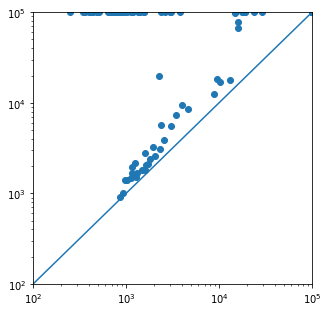

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(train_iterss.reshape(-1,), test_iterss.reshape(-1,))
plt.xscale('log')
plt.yscale('log')
plt.plot([1e2,1e5],[1e2,1e5])
plt.xlim(1e2,1e5)
plt.ylim(1e2,1e5)

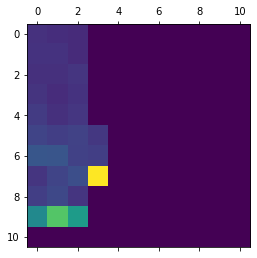

In [7]:
plt.matshow(np.transpose((train_iterss < (1e5-1)) * (test_iterss < (1e5-1)) * (test_iterss/train_iterss)))